In [ ]:
!pip install backtrader
!pip install ta

In [ ]:
import yfinance as yf
import backtrader as bt
import numpy as np
import pandas as pd
import math
from itertools import product
import datetime
import time
from datetime import timezone
import backtrader.plot
import matplotlib
import ta
import matplotlib.pyplot as plt

In [ ]:
# Download the stock's data
ticker = 'LOVE'
start_date = '2018-06-01'
end_date = '2023-06-01'
stockData = yf.download(ticker, start_date, end_date)

# Create in and out samples (0.75/0.25)
stockData_IS = stockData[:int(len(stockData)*0.75)]
stockData_OS = stockData[-int(len(stockData)*0.25):]

print(len(stockData), len(stockData_IS), len(stockData_OS))

actualStart = stockData.index[0]
data = bt.feeds.PandasData(dataname=stockData_IS)
test_data_OS = stockData_OS.copy()
last_day = stockData_OS.index[-2].date()

print('IS DATA: starting ', stockData_IS.index[0],' finshing ', stockData_IS.index[-1])
print('OS DATA: starting ', stockData_OS.index[0],' finshing ', stockData_OS.index[-1])

[*********************100%***********************]  1 of 1 completed
1240 930 310
IS DATA: starting  2018-06-27 00:00:00  finshing  2022-03-07 00:00:00
OS DATA: starting  2022-03-08 00:00:00  finshing  2023-05-31 00:00:00


In [ ]:
class RSI_BB(bt.Strategy):

    # list of parameters which are configurable for the strategy
    params = dict(
        period_bb=20,
        devfactor_bb=2,
        period_rsi=14,
        upperband_rsi=70,
        lowerband_rsi=30,
        stoptrail=0.03
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)


    def __init__(self):
        self.RSI = bt.ind.RSI_Safe(period=self.p.period_rsi,
                                   upperband=self.p.upperband_rsi,
                                   lowerband=self.p.lowerband_rsi)

        self.BBands = bt.ind.BollingerBands(period=self.p.period_bb,
                                            devfactor=self.p.devfactor_bb)

        self.trailing_stop = 0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        # Reset orders
        self.order = None

    def next(self):
        if not self.position:  # not in the market
            if self.RSI.lines.rsi <= self.p.lowerband_rsi and self.BBands.lines.bot >= self.data.close:
                self.order = self.buy()   # enter long
                self.trailing_stop = self.data.close * (1 - self.p.stoptrail)
            elif self.RSI.lines.rsi >= self.p.upperband_rsi and self.BBands.lines.top <= self.data.close:
                self.order = self.sell()
                self.trailing_stop = self.data.close * (1 + self.p.stoptrail)
        elif self.position.size < 0: # in short position
            if self.BBands.lines.mid >= self.data.close or self.data.close >= self.trailing_stop or self.datas[0].datetime.date(0) == last_day:
                self.order = self.close()
                self.trailing_stop = 0
        else: # in long position
            if self.data.close > self.BBands.lines.mid or self.data.close <= self.trailing_stop or self.datas[0].datetime.date(0) == last_day:
                self.order = self.close()
                self.trailing_stop = 0

In [ ]:
class maxRiskSizer(bt.Sizer):
    '''
    Returns the number of shares rounded down that can be purchased for the
    max rish tolerance
    '''
        # list of parameters which are configurable for the strategy
    params = dict(
        prisk=0.95
    )
    def __init__(self):
        if self.p.prisk > 1 or self.p.prisk < 0:
            raise ValueError('The risk parameter is a percentage which must be'
                'entered as a float. e.g. 0.5')
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy == True:
            size = math.floor((cash * self.p.prisk) / data[0])
        else:
            size = math.floor((cash * self.p.prisk) / data[0]) * -1
        return size

In [ ]:
def run(data, params , graph=False):
    #Add Data
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    #Analyzers
    cerebro.addanalyzer(bt.analyzers.AnnualReturn)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    cerebro.broker.set_cash(10000)
    cerebro.broker.setcommission(0.001)
    # Add Strategy
    cerebro.addstrategy(RSI_BB,
                        upperband_rsi=params[0],
                        lowerband_rsi=params[1],
                        period_bb=params[2])
    #Default position size
    cerebro.addsizer(maxRiskSizer, prisk=params[3])
    strats = cerebro.run()
    if graph:
        cerebro.plot(iplot=True, style='candlestick')
    return strats

In [ ]:
rsi_upper = range(60,70,2)
rsi_lower = range(30,40,2)
bb_period = range(15,25,2)
risk = np.linspace(0.25,1,4)


params = list(product(rsi_upper, rsi_lower, bb_period,risk))

optimized_runs = {}
for param in params:
    print(param)
    optimized_runs[param] = run(data, param)


(60, 30, 15, 0.25)
(60, 30, 15, 0.5)
(60, 30, 15, 0.75)
(60, 30, 15, 1.0)
(60, 30, 17, 0.25)
(60, 30, 17, 0.5)
(60, 30, 17, 0.75)
(60, 30, 17, 1.0)
(60, 30, 19, 0.25)
(60, 30, 19, 0.5)
(60, 30, 19, 0.75)
(60, 30, 19, 1.0)
(60, 30, 21, 0.25)
(60, 30, 21, 0.5)
(60, 30, 21, 0.75)
(60, 30, 21, 1.0)
(60, 30, 23, 0.25)
(60, 30, 23, 0.5)
(60, 30, 23, 0.75)
(60, 30, 23, 1.0)
(60, 32, 15, 0.25)
(60, 32, 15, 0.5)
(60, 32, 15, 0.75)
(60, 32, 15, 1.0)
(60, 32, 17, 0.25)
(60, 32, 17, 0.5)
(60, 32, 17, 0.75)
(60, 32, 17, 1.0)
(60, 32, 19, 0.25)
(60, 32, 19, 0.5)
(60, 32, 19, 0.75)
(60, 32, 19, 1.0)
(60, 32, 21, 0.25)
(60, 32, 21, 0.5)
(60, 32, 21, 0.75)
(60, 32, 21, 1.0)
(60, 32, 23, 0.25)
(60, 32, 23, 0.5)
(60, 32, 23, 0.75)
(60, 32, 23, 1.0)
(60, 34, 15, 0.25)
(60, 34, 15, 0.5)
(60, 34, 15, 0.75)
(60, 34, 15, 1.0)
(60, 34, 17, 0.25)
(60, 34, 17, 0.5)
(60, 34, 17, 0.75)
(60, 34, 17, 1.0)
(60, 34, 19, 0.25)
(60, 34, 19, 0.5)
(60, 34, 19, 0.75)
(60, 34, 19, 1.0)
(60, 34, 21, 0.25)
(60, 34, 21, 0.5)
(

In [ ]:
final_results_list = []
for runs in optimized_runs:
    for strategy in optimized_runs[runs]:
        PnL = round(strategy.broker.get_value() - 10000,2)
        sharpe = strategy.analyzers.sharpe_ratio.get_analysis()
        final_results_list.append([
            strategy.params.upperband_rsi,
            strategy.params.lowerband_rsi,
            strategy.params.period_bb,
            round(runs[3],2), PnL, round(sharpe['sharperatio'],2)])

sort_by_sharpe = sorted(final_results_list, key=lambda x: x[3],
                         reverse=True)

sort_by_sharpe = sorted(sort_by_sharpe, key=lambda x: x[5],
                         reverse=True)

for line in sort_by_sharpe[:]:
    print(line)

[62, 30, 15, 1.0, 7280.32, 0.65]
[60, 34, 15, 1.0, 11969.61, 0.59]
[60, 30, 15, 1.0, 12119.71, 0.58]
[62, 32, 15, 1.0, 16725.69, 0.58]
[60, 32, 15, 1.0, 15859.06, 0.56]
[62, 34, 15, 1.0, 9924.16, 0.53]
[64, 36, 15, 1.0, 7953.67, 0.39]
[62, 32, 17, 0.75, 4682.01, 0.37]
[62, 32, 17, 0.5, 3542.36, 0.37]
[60, 36, 15, 1.0, 5681.42, 0.36]
[60, 32, 17, 1.0, 5070.52, 0.35]
[60, 32, 17, 0.75, 4341.0, 0.35]
[60, 32, 17, 0.5, 3314.46, 0.35]
[62, 32, 17, 0.25, 1949.16, 0.35]
[62, 36, 17, 1.0, 4643.19, 0.34]
[66, 32, 21, 1.0, 3949.35, 0.34]
[66, 34, 15, 1.0, 5593.1, 0.34]
[62, 32, 15, 0.75, 4346.33, 0.33]
[62, 36, 15, 1.0, 4473.47, 0.32]
[62, 38, 15, 1.0, 4476.25, 0.32]
[64, 38, 15, 1.0, 4993.38, 0.32]
[66, 32, 15, 1.0, 4594.99, 0.32]
[60, 32, 15, 0.75, 4018.15, 0.32]
[64, 32, 17, 0.75, 3558.0, 0.32]
[60, 32, 17, 0.25, 1839.03, 0.32]
[64, 32, 17, 0.5, 2814.15, 0.31]
[60, 38, 15, 1.0, 4271.03, 0.3]
[62, 32, 15, 0.5, 3158.41, 0.3]
[64, 34, 15, 1.0, 3080.68, 0.29]
[64, 32, 15, 0.75, 3266.61, 0.29]
[60

In [ ]:
# Buy and Hold
def buy_and_hold():
    risk = sort_by_sharpe[0][3]
    cash_to_invest = 10000 * risk
    stock_price_buy = test_data_OS['Close'][0]
    stock_price_sell = test_data_OS['Close'][-1]
    number_of_bought_stocks = cash_to_invest / stock_price_buy
    end_balance = (10000 * (1 - risk)) + (number_of_bought_stocks * stock_price_sell)
    balance_return = (end_balance - 10000) / 10000
    return end_balance ,  balance_return


In [ ]:
best_params = (sort_by_sharpe[0][0], sort_by_sharpe[0][1], sort_by_sharpe[0][2], sort_by_sharpe[0][3])
data_OS = bt.feeds.PandasData(dataname=stockData_OS)
strats = run(data_OS, best_params)
strat_0 = strats[0]
portfolio_stats = strat_0.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
vol = np.std(returns)*np.sqrt(252)
returns.index = returns.index.tz_convert(None)
PnL = round(strat_0.broker.get_value() - 10000,2)
sharpe = strat_0.analyzers.sharpe_ratio.get_analysis()

In [ ]:
test_data = test_data_OS.copy()
test_data['rolling_mean'] = test_data['Close'].rolling(window=15).mean()
test_data['bb_upper_band'] = test_data['rolling_mean'] + 2 * test_data['Close'].rolling(window=15).std()
test_data['bb_lower_band'] = test_data['rolling_mean'] - 2 * test_data['Close'].rolling(window=15).std()
test_data['rsi'] = ta.momentum.RSIIndicator(test_data['Close']).rsi()
test_data.reset_index(drop=False, inplace=True)

In [ ]:
buy_signal1 = []
sell_signal1 = []
all_rsi = []
list1 = test_data.copy()

for r in range(len(transactions)):
  if transactions['amount'][r] > 0:
    for i in range(len(list1['Date'])):
      if list1['Date'][i].tz_localize('UTC') == transactions.index[r]:
        buy_signal1.append(list1['Date'][i])


  elif transactions['amount'][r] < 0:
    for i in range(len(list1['Date'])):
      if list1['Date'][i].tz_localize('UTC') == transactions.index[r]:
        sell_signal1.append(list1['Date'][i])


In [ ]:
list2 = test_data.copy()
list2.set_index('Date', inplace=True)

PnL $                  :  2901.62
Sharpe Ratio           :  1.37
Annualised Volatility %:  15.94


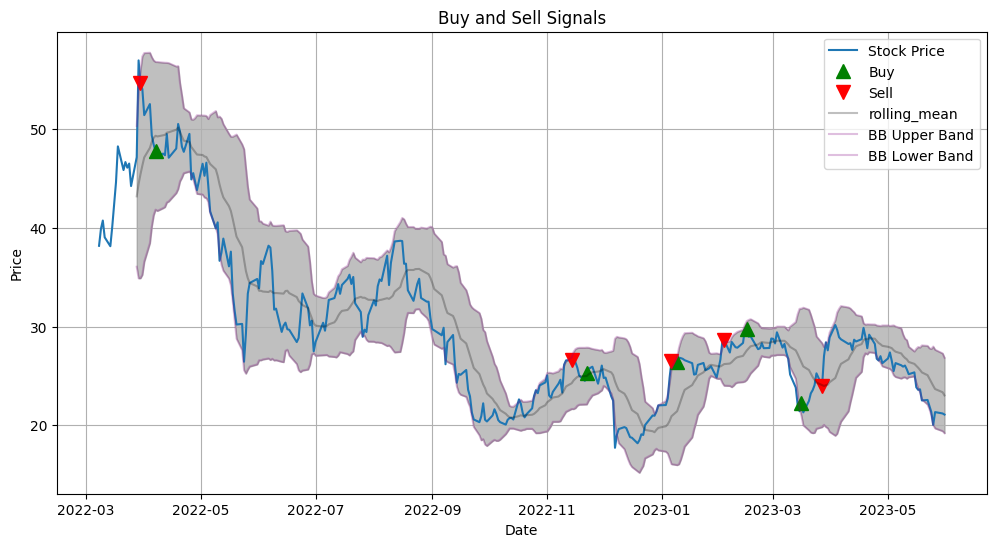

In [ ]:
buy_and_hold_balance ,  buy_and_hold_return = buy_and_hold()
print('PnL $                  : ',PnL)
print('Sharpe Ratio           : ',round(sharpe['sharperatio'],2))
print('Annualised Volatility %: ', round(vol*100,2))

plt.figure(figsize=(12, 6))
plt.plot(list2.index, list2['Close'], label='Stock Price')
plt.plot(buy_signal1, list2['Close'][buy_signal1], '^', markersize=10, color='g', label='Buy')
plt.plot(sell_signal1, list2['Close'][sell_signal1], 'v', markersize=10, color='r', label='Sell')

plt.plot(list2['rolling_mean'], label= 'rolling_mean', alpha = 0.25, color= 'black')
plt.plot(list2['bb_upper_band'], label= 'BB Upper Band', alpha = 0.25, color= 'purple')
plt.plot(list2['bb_lower_band'], label= 'BB Lower Band', alpha = 0.25, color='purple')
plt.fill_between(list2.index, list2['bb_upper_band'], list2['bb_lower_band'], color='grey', alpha = 0.5)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Buy and Sell Signals')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
print('Chosen stock:',ticker)
print('-----------------------')
print('Our stratagy profit: ',PnL , '$')
print('Our stratagy return: ',round(PnL / 100, 2), '%')
print('Buy and Hold profit: ',round(buy_and_hold_balance - 10000 , 2), '$')
print('Buy and Hold return: ',round(buy_and_hold_return * 100 , 2), '%')

Chosen stock: LOVE
-----------------------
Our stratagy profit:  2901.62 $
Our stratagy return:  29.02 %
Buy and Hold profit:  -4480.23 $
Buy and Hold return:  -44.8 %
